In [1]:
!pip3 install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import lit
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler   
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np    

In [3]:
spark = SparkSession.builder.appName('HW 9').getOrCreate()

21/11/21 18:02:00 WARN Utils: Your hostname, dylans-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.125 instead (on interface en0)
21/11/21 18:02:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/21 18:02:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

In [5]:
data_df = pd.read_csv("test2_new.txt", sep='|', names=['userID', 'trackID', 'predictions'])
data_df.head()

,userID,trackID,predictions
0,200031,30877,1
1,200031,8244,1
2,200031,130183,0
3,200031,198762,0
4,200031,34503,1


In [6]:
data2_df = pd.read_csv("output1.txt", sep='|', names=['userID', 'trackID', 'album_score', 'artist_score'])
data2_df.head()

,userID,trackID,album_score,artist_score
0,199810,208019,0.0,0.0
1,199810,74139,0.0,0.0
2,199810,9903,0.0,0.0
3,199810,242681,0.0,0.0
4,199810,18515,0.0,70.0


In [7]:
data2_df.columns[data2_df.isnull().any()] # check for null values

Index([], dtype='object')

In [8]:
scores_df = data_df.merge(data2_df, how='inner', on=['userID', 'trackID']) # inner join the dataframes
scores_df.head()

,userID,trackID,predictions,album_score,artist_score
0,200031,30877,1,90.0,50.0
1,200031,8244,1,90.0,0.0
2,200031,130183,0,0.0,0.0
3,200031,198762,0,0.0,0.0
4,200031,34503,1,90.0,50.0


In [9]:
scores_df.columns[scores_df.isnull().any()] # check for null values

Index([], dtype='object')

In [10]:
scores_df.to_csv('ratings.csv', index=False)
scores_df.count()

userID          6000
trackID         6000
predictions     6000
album_score     6000
artist_score    6000
dtype: int64

In [11]:
scores_df = spark.read.csv('ratings.csv', header=True, inferSchema=True)
scores_df.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- predictions: integer (nullable = true)
 |-- album_score: double (nullable = true)
 |-- artist_score: double (nullable = true)



In [12]:
numericCols = ['album_score', 'artist_score']
stages = []
assemblerInputs =  numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [13]:
label_stringIdx = StringIndexer(inputCol = 'predictions', outputCol = 'label')
stages += [label_stringIdx]

In [14]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(scores_df)
df = pipelineModel.transform(scores_df)
cols = scores_df.columns
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- predictions: integer (nullable = true)
 |-- album_score: double (nullable = true)
 |-- artist_score: double (nullable = true)



In [15]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1.0,1.0,0.0,0.0,1.0
features,"[90.0, 50.0]","[90.0, 0.0]","(0.0, 0.0)","(0.0, 0.0)","[90.0, 50.0]"
userID,200031,200031,200031,200031,200031
trackID,30877,8244,130183,198762,34503
predictions,1,1,0,0,1
album_score,90.0,90.0,0.0,0.0,90.0
artist_score,50.0,0.0,0.0,0.0,50.0


In [16]:
# below is the typical random split 
# of the train and test data sets
# HOWEVER, our testing users have 6 tracks for each
# We cannot use random split here
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 4260
Test Dataset Count: 1740


In [17]:
predictions_df = spark.read.csv('output1.txt', sep='|', inferSchema=True)

In [18]:
predictions_df.count()

120000

In [19]:
predictions_df

DataFrame[_c0: int, _c1: int, _c2: double, _c3: double]

In [20]:
predictions_df = predictions_df.withColumnRenamed("_c0", "userID").withColumnRenamed("_c1", "trackID").withColumnRenamed("_c2", "album_score").withColumnRenamed("_c3", "artist_score")

In [21]:
predictions_columns = predictions_df.columns
predictions_columns

['userID', 'trackID', 'album_score', 'artist_score']

In [22]:
predictions_df = predictions_df.withColumn('prediction', lit('0'))


In [23]:
pd.DataFrame(predictions_df.take(10), columns=predictions_df.columns).transpose()

,0,1,2,3,4,5,6,7,8,9
userID,199810,199810,199810,199810,199810,199810,199812,199812,199812,199812
trackID,208019,74139,9903,242681,18515,105760,276940,142408,130023,29189
album_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0
artist_score,0.0,0.0,0.0,0.0,70.0,90.0,0.0,100.0,100.0,0.0
prediction,0,0,0,0,0,0,0,0,0,0


In [24]:
predictions_df.printSchema()


root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- album_score: double (nullable = true)
 |-- artist_score: double (nullable = true)
 |-- prediction: string (nullable = false)



In [25]:
numericCols = ['album_score', 'artist_score']
stages = []
assemblerInputs =  numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [26]:
label_stringIdx = StringIndexer(inputCol = 'prediction', outputCol = 'label')
stages += [label_stringIdx]

In [27]:
predictions_pipeline = Pipeline(stages=stages)                       
predictions_pipeline_model = predictions_pipeline.fit(predictions_df)
predictions_df = predictions_pipeline_model.transform(predictions_df)

In [28]:
selected_columns = ['label', 'features'] + predictions_columns
predictions_df = predictions_df.select(selected_columns)
predictions_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- album_score: double (nullable = true)
 |-- artist_score: double (nullable = true)



In [29]:
pd.DataFrame(predictions_df.take(10), columns=predictions_df.columns).transpose()

,0,1,2,3,4,5,6,7,8,9
label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
features,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","[0.0, 70.0]","[0.0, 90.0]","(0.0, 0.0)","[100.0, 100.0]","[100.0, 100.0]","(0.0, 0.0)"
userID,199810,199810,199810,199810,199810,199810,199812,199812,199812,199812
trackID,208019,74139,9903,242681,18515,105760,276940,142408,130023,29189
album_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0
artist_score,0.0,0.0,0.0,0.0,70.0,90.0,0.0,100.0,100.0,0.0


# 1. Logistic regression model

In [30]:
from pyspark.ml.classification import LogisticRegression

In [31]:
logistic_regression = LogisticRegression(featuresCol = 'features', labelCol = 'label',)
logistic_regression_model = logistic_regression.fit(train)

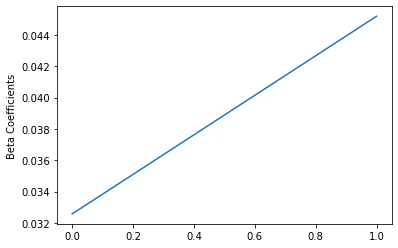

In [32]:
beta = np.sort(logistic_regression_model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

/Users/dylan/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


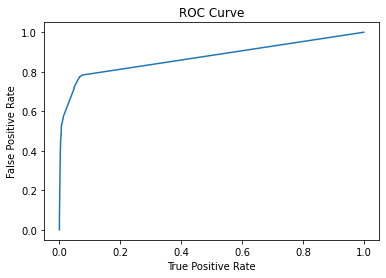

Training set areaUnderROC: 0.8737133978552075


In [33]:
trainingSummary = logistic_regression_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [34]:
predictions = logistic_regression_model.transform(test)
predictions.select('userID', 'trackID', 'label', 'probability', 
                   'rawPrediction', 'prediction' ).show(12)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200065| 179571|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200070| 124239|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200070| 271459|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200085| 134106|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200099|  41892|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200106| 152491|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200124| 284066|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200143| 131171|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200143| 187136|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200160| 231

In [35]:
# col("userID").asc() sort the user ascending
# col("probability").desc() sort the probability descending (from large to small)
from pyspark.sql.functions import col
sort_predictions = predictions.select('userID', 'trackID', 
                                      'label', 'probability', 
                                      'rawPrediction', 'prediction' 
                                     ).sort(col("userID").asc(), col("probability").desc())
sort_predictions.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200031|   8244|  1.0|[0.06488875729218...|[-2.6679911209111...|       1.0|
|200031|  30877|  1.0|[0.01343471003408...|[-4.2963878477543...|       1.0|
|200055|  56695|  1.0|[0.00368752576332...|[-5.5991052292289...|       1.0|
|200065| 179571|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200065| 119451|  1.0|[0.17782970128751...|[-1.5311211916575...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [36]:
# probability column is where you can decide 
# the 3 tracks with highest "probability" for "1" and 
# the 3 tracks with lowest "probability" for "0" 
# tracks "198762", "34503", "130183" with "1"
# tracks "30877", "8244", "227283" with "0"
sort_predictions.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200031|   8244|  1.0|[0.06488875729218...|[-2.6679911209111...|       1.0|
|200031|  30877|  1.0|[0.01343471003408...|[-4.2963878477543...|       1.0|
|200055|  56695|  1.0|[0.00368752576332...|[-5.5991052292289...|       1.0|
|200065| 179571|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200065| 119451|  1.0|[0.17782970128751...|[-1.5311211916575...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [37]:
logistic_regression_model_predictions = logistic_regression_model.transform(predictions_df)
logistic_regression_model_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|  74139|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|   9903|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810| 242681|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|  18515|[0.29322699696820...|[-0.8797625009202...|       1.0|
|199810| 105760|[0.17782970128751...|[-1.5311211916575...|       1.0|
|199812| 276940|[0.80218276453714...|[1.39999291666030...|       0.0|
|199812| 142408|[0.00169769820591...|[-6.3767828009944...|       1.0|
|199812| 130023|[0.00169769820591...|[-6.3767828009944...|       1.0|
|199812|  29189|[0.80218276453714...|[1.39999291666030...|       0.0|
|199812| 223706|[0.13507641145138...|[-1.8568005370262...|       1.0|
|199812| 211361|[0.8

In [38]:
sort_logistic_regression_model_predictions = logistic_regression_model_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_logistic_regression_model_predictions.show(6)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810| 242681|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|  74139|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|   9903|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|  18515|[0.29322699696820...|[-0.8797625009202...|       1.0|
|199810| 105760|[0.17782970128751...|[-1.5311211916575...|       1.0|
+------+-------+--------------------+--------------------+----------+
only showing top 6 rows



In [39]:
sort_logistic_regression_model_predictions_df = sort_logistic_regression_model_predictions.toPandas()
sort_logistic_regression_model_predictions_df.columns[sort_logistic_regression_model_predictions_df.isnull().any()]

Index([], dtype='object')

In [40]:
sort_logistic_regression_model_predictions_df.head()

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
1,199810,74139,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
2,199810,9903,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
3,199810,242681,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
4,199810,18515,"[0.2932269969682032, 0.7067730030317968]","[-0.8797625009202483, 0.8797625009202483]",1.0


In [41]:
columns = ['userID', 'trackID']
sort_logistic_regression_model_predictions_df.to_csv('logistic_regression_predictions.csv', index=False, header=None, columns=columns)

In [42]:
logistic_regression_predictions_file = open('logistic_regression_predictions.csv')                  
final_logistic_regression_predictions_file = open('logistic_regression_submission.csv', 'w')

In [43]:
final_logistic_regression_predictions_file.write('TrackID,Predictor\n')

18

In [44]:
last_user_id = -1
track_id_out_vec = [0] * 6

In [45]:
for line in logistic_regression_predictions_file:
    arr_out = line.strip().split(',')
    user_id_out = arr_out[0]
    track_id_out = arr_out[1]
    
    if user_id_out != last_user_id:
        i = 0
        
    track_id_out_vec[i] = track_id_out
        
    i = i + 1
    last_user_id = user_id_out
    
    if i == 6:
        predictions = np.ones(shape=(6))
        for index in range(0, 3):            
            predictions[index] = 0
        
        for ii in range(0, 6):         
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            final_logistic_regression_predictions_file.write(out_str + '\n')

In [46]:
logistic_regression_predictions_file.close()
final_logistic_regression_predictions_file.close()

# 2. Decision Tree Classifier

In [47]:
from pyspark.ml.classification import DecisionTreeClassifier

In [48]:
decision_tree_classifier = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=3)
decision_tree_classifier_model = decision_tree_classifier.fit(train)

In [49]:
predictions_decision_tree_classifier = decision_tree_classifier_model.transform(test)

In [50]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions_decision_tree_classifier)
print('Test Error: {}'.format((1.0 - accuracy) * 100))

Test Error: 14.482758620689651


In [51]:
sort_predictions_decision_tree_classifier = predictions_decision_tree_classifier.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_decision_tree_classifier.show(6)

+------+-------+-----+--------------------+--------------+----------+
|userID|trackID|label|         probability| rawPrediction|prediction|
+------+-------+-----+--------------------+--------------+----------+
|200031| 130183|  0.0|[0.80858085808580...|[1960.0,464.0]|       0.0|
|200031|  30877|  1.0|[0.08880090497737...|[157.0,1611.0]|       1.0|
|200031|   8244|  1.0|[0.01470588235294...|    [1.0,67.0]|       1.0|
|200055|  56695|  1.0|[0.08880090497737...|[157.0,1611.0]|       1.0|
|200065| 179571|  0.0|[0.80858085808580...|[1960.0,464.0]|       0.0|
|200065| 119451|  1.0|[0.08880090497737...|[157.0,1611.0]|       1.0|
+------+-------+-----+--------------------+--------------+----------+
only showing top 6 rows



In [52]:
predictions_decision_tree_classifier = decision_tree_classifier_model.transform(predictions_df)
predictions_decision_tree_classifier.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 276940|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199812| 142408|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 130023|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812|  29189|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199812| 223706|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 211361|[0.80858085808580...|[1960.0,464.0]|       0.0|
+------+-------+--------------------+---

In [53]:
sort_predictions_decision_tree_classifier = predictions_decision_tree_classifier.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_decision_tree_classifier.show(6)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
+------+-------+--------------------+--------------+----------+
only showing top 6 rows



In [54]:
sort_predictions_decision_tree_classifier_df = sort_predictions_decision_tree_classifier.toPandas()
sort_predictions_decision_tree_classifier_df.columns[sort_predictions_decision_tree_classifier_df.isnull().any()]

Index([], dtype='object')

In [55]:
sort_predictions_decision_tree_classifier_df.head()

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
1,199810,74139,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
2,199810,9903,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
3,199810,242681,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
4,199810,18515,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0


In [56]:
columns = ['userID', 'trackID']
sort_predictions_decision_tree_classifier_df.to_csv('decision_tree_classifier_predictions.csv', index=False, header=None, columns=columns)

In [57]:
decision_tree_classifier_file = open('decision_tree_classifier_predictions.csv')   
final_decision_tree_classifier_file = open('decision_tree_classifier_submission.csv', 'w')

In [58]:
final_decision_tree_classifier_file.write('TrackID,Predictor\n')

18

In [59]:
last_user_id = -1
track_id_out_vec = [0] * 6

In [60]:
for line in decision_tree_classifier_file:
    arr_out = line.strip().split(',')
    user_id_out = arr_out[0]
    track_id_out = arr_out[1]
    
    if user_id_out != last_user_id:
        i = 0
        
    track_id_out_vec[i] = track_id_out
        
    i = i + 1
    last_user_id = user_id_out
    if i == 6:
        predictions = np.ones(shape=(6))
        for index in range(0, 3):            
            predictions[index] = 0
        
        for ii in range(0, 6):         
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            final_decision_tree_classifier_file.write(out_str + '\n')

In [61]:
decision_tree_classifier_file.close()
final_decision_tree_classifier_file.close()

# 3. Random Forest Classifier

In [62]:
from pyspark.ml.classification import RandomForestClassifier

In [63]:
random_forest = RandomForestClassifier(featuresCol='features', labelCol='label')
random_forest_model = random_forest.fit(train)

In [64]:
random_forest_predictions = random_forest_model.transform(test)

In [65]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(random_forest_predictions)
print('Test Error: {}'.format((1.0 - accuracy) * 100))

Test Error: 14.482758620689651


In [66]:
sort_random_forest_predictions = random_forest_predictions.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_random_forest_predictions.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80878408351365...|[16.1756816702730...|       0.0|
|200031|  30877|  1.0|[0.01263507637292...|[0.25270152745857...|       1.0|
|200031|   8244|  1.0|[8.06451612903225...|[0.01612903225806...|       1.0|
|200055|  56695|  1.0|[0.01263507637292...|[0.25270152745857...|       1.0|
|200065| 179571|  0.0|[0.80878408351365...|[16.1756816702730...|       0.0|
|200065| 119451|  1.0|[0.18553913276044...|[3.71078265520889...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [67]:
random_forest_predictions = random_forest_model.transform(predictions_df)
random_forest_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80878408351365...|[16.1756816702730...|       0.0|
|199810|  74139|[0.80878408351365...|[16.1756816702730...|       0.0|
|199810|   9903|[0.80878408351365...|[16.1756816702730...|       0.0|
|199810| 242681|[0.80878408351365...|[16.1756816702730...|       0.0|
|199810|  18515|[0.19467261212938...|[3.89345224258761...|       1.0|
|199810| 105760|[0.18553913276044...|[3.71078265520889...|       1.0|
|199812| 276940|[0.80878408351365...|[16.1756816702730...|       0.0|
|199812| 142408|[0.01263507637292...|[0.25270152745857...|       1.0|
|199812| 130023|[0.01263507637292...|[0.25270152745857...|       1.0|
|199812|  29189|[0.80878408351365...|[16.1756816702730...|       0.0|
|199812| 223706|[0.18553913276044...|[3.71078265520889...|       1.0|
|199812| 211361|[0.8

In [68]:
sort_random_forest_predictions = random_forest_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_random_forest_predictions.show(6)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80878408351365...|[16.1756816702730...|       0.0|
|199810| 242681|[0.80878408351365...|[16.1756816702730...|       0.0|
|199810|  74139|[0.80878408351365...|[16.1756816702730...|       0.0|
|199810|   9903|[0.80878408351365...|[16.1756816702730...|       0.0|
|199810|  18515|[0.19467261212938...|[3.89345224258761...|       1.0|
|199810| 105760|[0.18553913276044...|[3.71078265520889...|       1.0|
+------+-------+--------------------+--------------------+----------+
only showing top 6 rows



In [69]:
sort_random_forest_predictions_df = sort_random_forest_predictions.toPandas()
sort_random_forest_predictions_df.columns[sort_random_forest_predictions_df.isnull().any()]

Index([], dtype='object')

In [70]:
sort_random_forest_predictions_df.head()

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8087840835136524, 0.19121591648634775]","[16.175681670273047, 3.824318329726955]",0.0
1,199810,74139,"[0.8087840835136524, 0.19121591648634775]","[16.175681670273047, 3.824318329726955]",0.0
2,199810,9903,"[0.8087840835136524, 0.19121591648634775]","[16.175681670273047, 3.824318329726955]",0.0
3,199810,242681,"[0.8087840835136524, 0.19121591648634775]","[16.175681670273047, 3.824318329726955]",0.0
4,199810,18515,"[0.1946726121293807, 0.8053273878706193]","[3.893452242587614, 16.106547757412386]",1.0


In [71]:
columns= ['userID', 'trackID']
sort_random_forest_predictions_df.to_csv('random_forest_classifier_predictions.csv', index=False, header=None, columns=columns)

In [72]:
random_forest_predictions_file = open('random_forest_classifier_predictions.csv')   
final_random_forest_predictions_file = open('random_forest_classifier_submission.csv', 'w')

In [73]:
final_random_forest_predictions_file.write('TrackID,Predictor\n')

18

In [74]:
last_user_id = -1
track_id_out_vec = [0] * 6

In [75]:
for line in random_forest_predictions_file:
    arr_out = line.strip().split(',')
    user_id_out = arr_out[0]
    track_id_out = arr_out[1]
    
    if user_id_out != last_user_id:
        i = 0
        
    track_id_out_vec[i] = track_id_out
        
    i = i + 1
    last_user_id = user_id_out
    
    if i == 6:
        predictions = np.ones(shape=(6))
        for index in range(0, 3):            
            predictions[index] = 0
            
        for ii in range(0, 6):         
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            final_random_forest_predictions_file.write(out_str + '\n')

In [76]:
random_forest_predictions_file.close()
final_random_forest_predictions_file.close()

# 4. Gradient Boosted Tree Classifier

In [77]:
from pyspark.ml.classification import GBTClassifier

In [78]:
gradient_boosted_tree_classifier = GBTClassifier(maxIter=100)
gradient_boosted_tree_classifier_model = gradient_boosted_tree_classifier.fit(train)

In [79]:
gradient_boosted_tree_classifier_predictions = gradient_boosted_tree_classifier_model.transform(test)

In [80]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(gradient_boosted_tree_classifier_predictions)
print('Test Error: {}'.format((1.0 - accuracy) * 100))

Test Error: 14.482758620689651


21/11/21 18:03:08 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/11/21 18:03:08 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [81]:
sort_gradient_boosted_tree_classifier_predictions = gradient_boosted_tree_classifier_predictions.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_gradient_boosted_tree_classifier_predictions.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80853359039673...|[0.72025491912707...|       0.0|
|200031|  30877|  1.0|[0.01165681655269...|[-2.2200694341913...|       1.0|
|200031|   8244|  1.0|[0.01165681655269...|[-2.2200694341913...|       1.0|
|200055|  56695|  1.0|[0.01632026531261...|[-2.0494463824457...|       1.0|
|200065| 179571|  0.0|[0.80853359039673...|[0.72025491912707...|       0.0|
|200065| 119451|  1.0|[0.19777096337535...|[-0.7001422692047...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [82]:
gradient_boosted_tree_classifier_predictions = gradient_boosted_tree_classifier_model.transform(predictions_df)
gradient_boosted_tree_classifier_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  74139|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|   9903|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810| 242681|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  18515|[0.24633418901301...|[-0.5591299711568...|       1.0|
|199810| 105760|[0.19777096337535...|[-0.7001422692047...|       1.0|
|199812| 276940|[0.80853359039673...|[0.72025491912707...|       0.0|
|199812| 142408|[0.01161609118736...|[-2.2218399428711...|       1.0|
|199812| 130023|[0.01161609118736...|[-2.2218399428711...|       1.0|
|199812|  29189|[0.80853359039673...|[0.72025491912707...|       0.0|
|199812| 223706|[0.12602709898363...|[-0.9682762071735...|       1.0|
|199812| 211361|[0.8

In [83]:
sort_gradient_boosted_tree_classifier_predictions = gradient_boosted_tree_classifier_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_gradient_boosted_tree_classifier_predictions.show(6)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810| 242681|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  74139|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|   9903|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  18515|[0.24633418901301...|[-0.5591299711568...|       1.0|
|199810| 105760|[0.19777096337535...|[-0.7001422692047...|       1.0|
+------+-------+--------------------+--------------------+----------+
only showing top 6 rows



In [84]:
sort_gradient_boosted_tree_classifier_predictions_df = sort_gradient_boosted_tree_classifier_predictions.toPandas()
sort_gradient_boosted_tree_classifier_predictions_df.columns[sort_gradient_boosted_tree_classifier_predictions_df.isnull().any()]

Index([], dtype='object')

In [85]:
sort_gradient_boosted_tree_classifier_predictions_df.head()

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270777, -0.7202549191270777]",0.0
1,199810,74139,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270777, -0.7202549191270777]",0.0
2,199810,9903,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270777, -0.7202549191270777]",0.0
3,199810,242681,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270777, -0.7202549191270777]",0.0
4,199810,18515,"[0.24633418901301743, 0.7536658109869826]","[-0.5591299711568518, 0.5591299711568518]",1.0


In [86]:
columns = ['userID', 'trackID']
sort_gradient_boosted_tree_classifier_predictions_df.to_csv('gradient_boosted_tree_classifier_predictions.csv', index=False, header=None, columns=columns)

In [87]:
gradient_boosted_tree_classifier_predictions_file = open('gradient_boosted_tree_classifier_predictions.csv')   
final_gradient_boosted_tree_classifier_predictions_file = open('gradient_boosted_tree_classifier_submission.csv', 'w')

In [88]:
final_gradient_boosted_tree_classifier_predictions_file.write('TrackID,Predictor\n')

18

In [89]:
last_user_id = -1
track_id_out_vec = [0] * 6

In [90]:
for line in gradient_boosted_tree_classifier_predictions_file:
    arr_out = line.strip().split(',')
    user_id_out = arr_out[0]
    track_id_out = arr_out[1]
    
    if user_id_out != last_user_id:
        i = 0
        
    track_id_out_vec[i] = track_id_out
        
    i = i + 1
    last_user_id = user_id_out
    
    if i == 6:
        predictions = np.ones(shape=(6))
        for index in range(0, 3):            
            predictions[index] = 0
        
        for ii in range(0, 6):         
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            final_gradient_boosted_tree_classifier_predictions_file.write(out_str + '\n')

In [91]:
gradient_boosted_tree_classifier_predictions_file.close()
final_gradient_boosted_tree_classifier_predictions_file.close()